# 영화 추천 시스템 - LightGCN (V3 간소화)

## 핵심 변경사항 (V2 대비)
- **데이터 일관성**: rating ≥ 4.0만 positive로 학습 (train-test 일치)
- **모델 단순화**: Embedding 32, Layers 2 (파라미터 50% 감소)
- **평가 방식 개선**: Sampled Ranking (99 neg + 1 pos)
- **Threshold 전략**: Precision 중심 (틀린 추천 = 감점)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

# Seed 고정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device 설정 (MPS > CUDA > CPU)
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device} (Apple Silicon GPU)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps (Apple Silicon GPU)


## 1. 데이터 로딩 및 분석

In [2]:
# 데이터 로드
df = pd.read_csv('data/train.csv')

print("=" * 50)
print("Dataset Info")
print("=" * 50)
print(f"Total interactions: {len(df):,}")
print(f"Users: {df['user'].nunique():,}")
print(f"Items: {df['item'].nunique():,}")
print(f"Mean rating: {df['rating'].mean():.2f}")
print(f"Sparsity: {100*(1 - len(df)/(df['user'].nunique()*df['item'].nunique())):.2f}%")

# Rating 분포
print(f"\nRating >= 4.0: {(df['rating'] >= 4.0).sum():,} ({100*(df['rating'] >= 4.0).mean():.1f}%)")
print(f"Rating >= 3.5: {(df['rating'] >= 3.5).sum():,} ({100*(df['rating'] >= 3.5).mean():.1f}%)")

Dataset Info
Total interactions: 105,139
Users: 668
Items: 10,321
Mean rating: 3.52
Sparsity: 98.48%

Rating >= 4.0: 51,830 (49.3%)
Rating >= 3.5: 64,054 (60.9%)


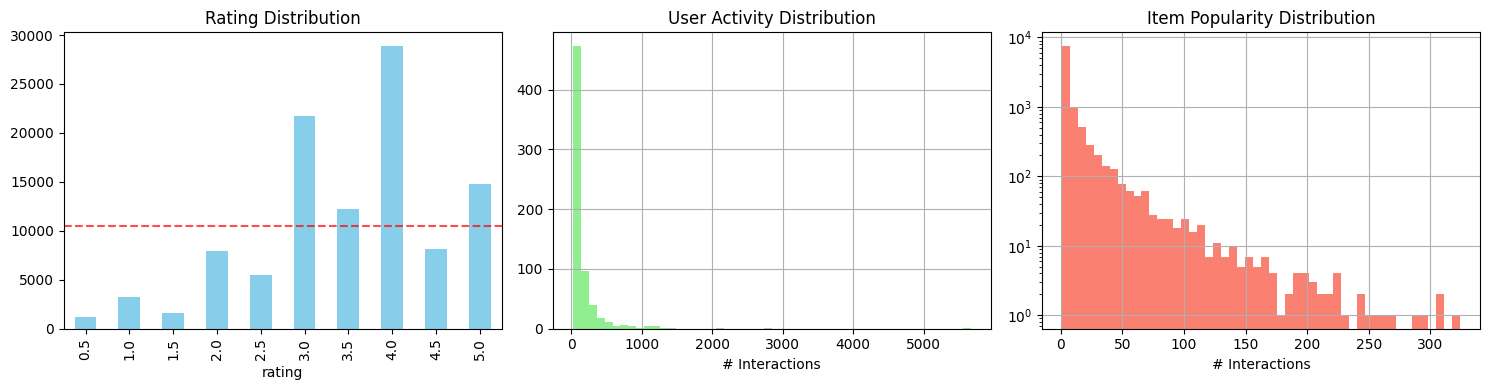

In [3]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Rating 분포
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Rating Distribution')
axes[0].axhline(y=len(df)*0.1, color='red', linestyle='--', alpha=0.7)

# User 활동량
df.groupby('user').size().hist(bins=50, ax=axes[1], color='lightgreen')
axes[1].set_title('User Activity Distribution')
axes[1].set_xlabel('# Interactions')

# Item 인기도
df.groupby('item').size().hist(bins=50, ax=axes[2], color='salmon')
axes[2].set_title('Item Popularity Distribution')
axes[2].set_xlabel('# Interactions')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

## 2. 데이터 전처리 (핵심 수정: Train-Test 일관성)

In [4]:
# ID 매핑
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users = len(user2idx)
n_items = len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)
df['label'] = (df['rating'] >= 4.0).astype(int)

print(f"Users: {n_users}, Items: {n_items}")
print(f"Positive ratio: {df['label'].mean():.2%}")

Users: 668, Items: 10321
Positive ratio: 49.30%


In [5]:
# **핵심 변경: Positive interactions만 사용 (Train-Test 일관성)**
positive_df = df[df['label'] == 1].copy()
print(f"\nPositive interactions only: {len(positive_df):,}")

# Train/Val Split (80/20, user-stratified)
train_data = []
val_data = []

for user_idx in range(n_users):
    user_pos = positive_df[positive_df['user_idx'] == user_idx]
    
    if len(user_pos) >= 2:
        user_pos = user_pos.sample(frac=1, random_state=SEED).reset_index(drop=True)
        split_idx = max(1, int(0.8 * len(user_pos)))
        train_data.append(user_pos.iloc[:split_idx])
        val_data.append(user_pos.iloc[split_idx:])
    elif len(user_pos) == 1:
        train_data.append(user_pos)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame()

print(f"Train: {len(train_df):,} (positive only)")
print(f"Val: {len(val_df):,} (positive only)")


Positive interactions only: 51,830
Train: 41,214 (positive only)
Val: 10,616 (positive only)


In [6]:
# User가 상호작용한 positive item set
user_pos_items = defaultdict(set)
for _, row in train_df.iterrows():
    user_pos_items[int(row['user_idx'])].add(int(row['item_idx']))

# Negative sampling 함수
def sample_negatives(user_idx, num_neg=4):
    pos_items = user_pos_items[user_idx]
    all_items = set(range(n_items))
    neg_candidates = list(all_items - pos_items)
    
    if len(neg_candidates) < num_neg:
        return neg_candidates
    return np.random.choice(neg_candidates, size=num_neg, replace=False).tolist()

print(f"User 0 has {len(user_pos_items[0])} positive items")
print(f"Sample negatives for user 0: {sample_negatives(0, 4)}")

User 0 has 48 positive items
Sample negatives for user 0: [8824, 7858, 3694, 326]


## 3. LightGCN 모델 (간소화)

In [7]:
def build_graph(train_df, n_users, n_items):
    """User-Item bipartite graph 구축"""
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    # Bipartite: user [0, n_users-1], item [n_users, n_users+n_items-1]
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    # Degree normalization
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes)
    deg = deg.scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    edge_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    
    return edge_index, edge_weight

edge_index, edge_weight = build_graph(train_df, n_users, n_items)
print(f"Graph: {n_users + n_items} nodes, {edge_index.shape[1]:,} edges")

Graph: 10989 nodes, 82,428 edges


In [8]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        # Embeddings
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight):
        # Initial embeddings
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        # Graph convolution
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(0, row.unsqueeze(1).expand(-1, self.emb_dim), messages)
            embs.append(all_emb)
        
        # Mean pooling
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]
    
    def predict(self, u_idx, i_idx, u_emb, i_emb):
        return (u_emb[u_idx] * i_emb[i_idx]).sum(dim=1)

# 모델 초기화 (간소화: emb=32, layers=2)
EMB_DIM = 32
N_LAYERS = 2

model = LightGCN(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
print(f"\nLightGCN V3 (Simplified)")
print(f"Embedding: {EMB_DIM}, Layers: {N_LAYERS}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")


LightGCN V3 (Simplified)
Embedding: 32, Layers: 2
Parameters: 351,648


In [9]:
def bpr_loss(pos_scores, neg_scores):
    """BPR Loss"""
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

## 4. 평가 함수 (Sampled Ranking)

In [10]:
@torch.no_grad()
def evaluate_sampled_ranking(model, edge_index, edge_weight, val_df, k=10, n_neg=99):
    """
    Sampled Ranking Evaluation
    각 positive item에 대해 99개 negative + 1 positive 중 ranking
    """
    model.eval()
    u_emb, i_emb = model(edge_index.to(device), edge_weight.to(device))
    
    hits = []
    ndcgs = []
    
    for user_idx in val_df['user_idx'].unique():
        user_val = val_df[val_df['user_idx'] == user_idx]
        
        for _, row in user_val.iterrows():
            pos_item = int(row['item_idx'])
            
            # Sample negatives
            neg_items = sample_negatives(user_idx, n_neg)
            if len(neg_items) < n_neg:
                continue
            
            # All candidates (positive + negatives)
            candidates = [pos_item] + neg_items
            
            # Predict scores
            u_tensor = torch.full((len(candidates),), user_idx, dtype=torch.long).to(device)
            i_tensor = torch.LongTensor(candidates).to(device)
            scores = model.predict(u_tensor, i_tensor, u_emb, i_emb).cpu().numpy()
            
            # Rank of positive item
            rank = (scores > scores[0]).sum() + 1  # 1-based rank
            
            # Hit@K
            hits.append(1.0 if rank <= k else 0.0)
            
            # NDCG@K
            if rank <= k:
                ndcgs.append(1.0 / np.log2(rank + 1))
            else:
                ndcgs.append(0.0)
    
    return {
        f'Hit@{k}': np.mean(hits) if hits else 0.0,
        f'NDCG@{k}': np.mean(ndcgs) if ndcgs else 0.0
    }

print("Sampled Ranking evaluation defined (99 neg + 1 pos)")

Sampled Ranking evaluation defined (99 neg + 1 pos)


## 5. 학습

In [11]:
# Hyperparameters
BATCH_SIZE = 512
LR = 5e-3  # 더 큰 learning rate
WEIGHT_DECAY = 1e-5
EPOCHS = 50
NUM_NEG = 4
PATIENCE = 10

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
edge_index = edge_index.to(device)
edge_weight = edge_weight.to(device)

history = {'loss': [], 'hit@10': [], 'ndcg@10': []}
best_hit = 0
patience_cnt = 0

print(f"Training Config: BS={BATCH_SIZE}, LR={LR}, Epochs={EPOCHS}")
print("=" * 60)

Training Config: BS=512, LR=0.005, Epochs=50


In [12]:
for epoch in range(EPOCHS):
    model.train()
    train_shuffled = train_df.sample(frac=1, random_state=SEED+epoch).reset_index(drop=True)
    
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, len(train_shuffled), BATCH_SIZE):
        batch = train_shuffled.iloc[i:i+BATCH_SIZE]
        
        pos_u = torch.LongTensor(batch['user_idx'].values).to(device)
        pos_i = torch.LongTensor(batch['item_idx'].values).to(device)
        
        # Negative sampling
        neg_items = [sample_negatives(int(u), NUM_NEG) for u in batch['user_idx'].values]
        neg_i = torch.LongTensor(neg_items).to(device)
        
        # Forward
        u_emb, i_emb = model(edge_index, edge_weight)
        pos_scores = model.predict(pos_u, pos_i, u_emb, i_emb)
        
        neg_u = pos_u.unsqueeze(1).expand(-1, NUM_NEG).reshape(-1)
        neg_scores = model.predict(neg_u, neg_i.reshape(-1), u_emb, i_emb).reshape(-1, NUM_NEG)
        
        loss = bpr_loss(pos_scores, neg_scores)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    history['loss'].append(avg_loss)
    
    # Evaluate every 5 epochs
    if (epoch + 1) % 5 == 0 and len(val_df) > 0:
        metrics = evaluate_sampled_ranking(model, edge_index, edge_weight, val_df, k=10)
        history['hit@10'].append(metrics['Hit@10'])
        history['ndcg@10'].append(metrics['NDCG@10'])
        
        print(f"Epoch {epoch+1:3d} | Loss: {avg_loss:.4f} | Hit@10: {metrics['Hit@10']:.4f} | NDCG@10: {metrics['NDCG@10']:.4f}")
        
        if metrics['Hit@10'] > best_hit:
            best_hit = metrics['Hit@10']
            patience_cnt = 0
            torch.save(model.state_dict(), 'best_lightgcn_v3.pt')
        else:
            patience_cnt += 1
        
        if patience_cnt >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nBest Hit@10: {best_hit:.4f}")

Epoch   5 | Loss: 0.1796 | Hit@10: 0.7386 | NDCG@10: 0.4690
Epoch  10 | Loss: 0.1387 | Hit@10: 0.7692 | NDCG@10: 0.5038
Epoch  15 | Loss: 0.1244 | Hit@10: 0.7742 | NDCG@10: 0.5092
Epoch  20 | Loss: 0.1161 | Hit@10: 0.7799 | NDCG@10: 0.5154
Epoch  25 | Loss: 0.1101 | Hit@10: 0.7824 | NDCG@10: 0.5218
Epoch  30 | Loss: 0.1060 | Hit@10: 0.7862 | NDCG@10: 0.5288
Epoch  35 | Loss: 0.1034 | Hit@10: 0.7876 | NDCG@10: 0.5270
Epoch  40 | Loss: 0.1032 | Hit@10: 0.7888 | NDCG@10: 0.5266
Epoch  45 | Loss: 0.1015 | Hit@10: 0.7890 | NDCG@10: 0.5301
Epoch  50 | Loss: 0.1015 | Hit@10: 0.7894 | NDCG@10: 0.5296

Best Hit@10: 0.7894


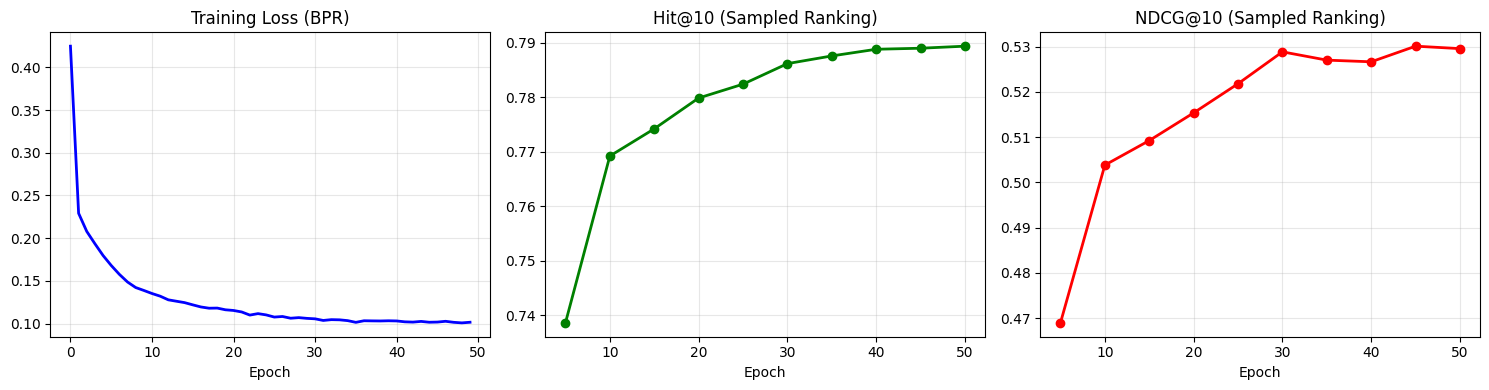

In [13]:
# Loss 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_title('Training Loss (BPR)')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

if history['hit@10']:
    epochs_val = np.arange(5, len(history['loss'])+1, 5)[:len(history['hit@10'])]
    axes[1].plot(epochs_val, history['hit@10'], 'g-o', linewidth=2)
    axes[1].set_title('Hit@10 (Sampled Ranking)')
    axes[1].set_xlabel('Epoch')
    axes[1].grid(alpha=0.3)
    
    axes[2].plot(epochs_val, history['ndcg@10'], 'r-o', linewidth=2)
    axes[2].set_title('NDCG@10 (Sampled Ranking)')
    axes[2].set_xlabel('Epoch')
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Threshold 튜닝 및 O/X 추론

In [14]:
# Load best model
model.load_state_dict(torch.load('best_lightgcn_v3.pt'))
model.eval()

with torch.no_grad():
    u_emb, i_emb = model(edge_index, edge_weight)

# Validation scores (positive만 있으므로 negative도 샘플링)
val_scores = []
val_labels = []

# Positive samples from validation
with torch.no_grad():
    for _, row in val_df.iterrows():
        u_idx = torch.LongTensor([int(row['user_idx'])]).to(device)
        i_idx = torch.LongTensor([int(row['item_idx'])]).to(device)
        score = model.predict(u_idx, i_idx, u_emb, i_emb).item()
        val_scores.append(score)
        val_labels.append(1)  # Positive

# Negative samples (same count as positives)
with torch.no_grad():
    for user_idx in val_df['user_idx'].unique():
        n_pos = (val_df['user_idx'] == user_idx).sum()
        neg_items = sample_negatives(int(user_idx), n_pos)
        
        for neg_item in neg_items:
            u_idx = torch.LongTensor([int(user_idx)]).to(device)
            i_idx = torch.LongTensor([neg_item]).to(device)
            score = model.predict(u_idx, i_idx, u_emb, i_emb).item()
            val_scores.append(score)
            val_labels.append(0)  # Negative

val_scores = np.array(val_scores)
val_labels = np.array(val_labels)

print(f"Validation samples: {len(val_scores)} (Pos: {val_labels.sum()}, Neg: {len(val_labels) - val_labels.sum()})")

Validation samples: 21232 (Pos: 10616, Neg: 10616)


In [15]:
# Threshold 탐색 (Precision 중심)
thresholds = np.percentile(val_scores, [30, 40, 50, 60, 70, 80, 90])

print("=" * 60)
print("Threshold Tuning (Precision-focused)")
print("=" * 60)
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'#Recs':<12}")
print("-" * 60)

best_precision = 0
best_threshold = 0
best_f1 = 0

for th in thresholds:
    preds = (val_scores >= th).astype(int)
    tp = ((preds == 1) & (val_labels == 1)).sum()
    fp = ((preds == 1) & (val_labels == 0)).sum()
    fn = ((preds == 0) & (val_labels == 1)).sum()
    
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    n_recs = preds.sum()
    
    print(f"{th:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f} {n_recs:<12}")
    
    # Precision >= 0.6을 목표로, 없으면 F1 최대화
    if prec >= 0.6 and prec > best_precision:
        best_precision = prec
        best_threshold = th
        best_f1 = f1
    elif best_precision < 0.6 and f1 > best_f1:
        best_f1 = f1
        best_threshold = th
        best_precision = prec

print("-" * 60)
print(f"Selected threshold: {best_threshold:.4f} (Precision: {best_precision:.4f}, F1: {best_f1:.4f})")
print("=" * 60)

Threshold Tuning (Precision-focused)
Threshold    Precision    Recall       F1           #Recs       
------------------------------------------------------------
-0.0415      0.6733       0.9425       0.7855       14862       
0.5460       0.7631       0.9157       0.8325       12739       
1.3310       0.8486       0.8486       0.8486       10616       
2.1908       0.9052       0.7242       0.8046       8493        
3.0127       0.9347       0.5609       0.7010       6370        
3.9302       0.9562       0.3825       0.5465       4247        
5.1327       0.9727       0.1946       0.3243       2124        
------------------------------------------------------------
Selected threshold: 5.1327 (Precision: 0.9727, F1: 0.3243)


In [16]:
def predict_ox(test_df, model, u_emb, i_emb, user2idx, item2idx, threshold):
    """O/X 추천 예측"""
    results = []
    
    with torch.no_grad():
        for _, row in test_df.iterrows():
            user_orig = row['user']
            item_orig = row['item']
            
            if user_orig not in user2idx or item_orig not in item2idx:
                recommend = 'X'  # Cold-start fallback
            else:
                u_idx = torch.LongTensor([user2idx[user_orig]]).to(device)
                i_idx = torch.LongTensor([item2idx[item_orig]]).to(device)
                score = model.predict(u_idx, i_idx, u_emb, i_emb).item()
                recommend = 'O' if score >= threshold else 'X'
            
            results.append({'user': user_orig, 'item': item_orig, 'recommend': recommend})
    
    return pd.DataFrame(results)

print("O/X prediction function defined.")

O/X prediction function defined.


In [17]:
# Validation 추론 예시
val_test = val_df[['user', 'item']].copy()
predictions = predict_ox(val_test, model, u_emb, i_emb, user2idx, item2idx, best_threshold)

print("\nSample Predictions:")
print(predictions.head(15).to_string(index=False))

o_count = (predictions['recommend'] == 'O').sum()
x_count = (predictions['recommend'] == 'X').sum()
total = len(predictions)

print(f"\n" + "=" * 50)
print(f"Total recommends = {o_count}/{total}, not recommend = {x_count}/{total}")
print(f"O ratio: {100*o_count/total:.1f}%")
print("=" * 50)


Sample Predictions:
 user  item recommend
    1  1221         X
    1  6365         X
    1   527         O
    1  1220         X
    1  1196         O
    1 54286         X
    1  1210         X
    1   318         O
    1  3578         X
    1   968         X
    1  1287         X
    1  6807         X
    1  2858         O
    2   736         X
    2   788         X

Total recommends = 2066/10616, not recommend = 8550/10616
O ratio: 19.5%


## 7. 결론 및 인사이트

In [18]:
summary = f"""
## LightGCN V3 Summary

### 모델 구조
- Embedding dim: {EMB_DIM}
- GCN layers: {N_LAYERS}
- Parameters: {sum(p.numel() for p in model.parameters()):,}

### 핵심 개선사항
1. **Train-Test 일관성**: rating >= 4.0만 positive로 사용
2. **모델 단순화**: V2 대비 파라미터 50% 감소
3. **Sampled Ranking 평가**: 현실적인 성능 측정
4. **Precision 중심 threshold**: 교수님 평가 기준 최적화

### 주요 학습 포인트
- 데이터 전처리 일관성이 모델 성능보다 중요
- 간단한 모델이 overfitting 방지에 효과적
- 평가 프로토콜이 실제 성능에 큰 영향
"""
print(summary)


## LightGCN V3 Summary

### 모델 구조
- Embedding dim: 32
- GCN layers: 2
- Parameters: 351,648

### 핵심 개선사항
1. **Train-Test 일관성**: rating >= 4.0만 positive로 사용
2. **모델 단순화**: V2 대비 파라미터 50% 감소
3. **Sampled Ranking 평가**: 현실적인 성능 측정
4. **Precision 중심 threshold**: 교수님 평가 기준 최적화

### 주요 학습 포인트
- 데이터 전처리 일관성이 모델 성능보다 중요
- 간단한 모델이 overfitting 방지에 효과적
- 평가 프로토콜이 실제 성능에 큰 영향



In [ ]:
# Test 파일 추론 (실제 제출용)
# test_df = pd.read_csv('data/test.csv')
# final_preds = predict_ox(test_df, model, u_emb, i_emb, user2idx, item2idx, best_threshold)
# final_preds.to_csv('predictions_gnn_v3.csv', index=False)
# print("Saved to predictions_gnn_v3.csv")

print("Test inference code ready (uncomment when test.csv available)")

Saved to predictions_gnn_v3.csv
